## Importing Libraries

In [2]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

# Visualization
import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Reading the Data

In [4]:
# Read infection time data
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

#TRY THIS ONE:
# Read temperature data
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"

files = glob.glob( folder + "Ex *.xlsx" ) 

#minutes = []
temp = []

for file in files:
    df = pd.read_excel(file)
    
    #file_min = df.iloc[:, 0]  # getting only the minutes
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    #file_min = file_min[:num_temp_columns]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        #minutes_subset = file_min
        
        # Append the temperature and minutes to each lists
        #minutes.append(minutes_subset)
        temp.append(temperature)


## Creating Data Frames

In [5]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
#infection_data.head()
infection_data = infection_data.T
#infection_data

# Assign the values of the first row as the new column names
infection_data.columns = infection_data.iloc[0]

# Remove the first row (previous column names)
infection_data = infection_data[1:]
#infection_data.head()

##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T
#df_temp.head()

# Rename columns keeping only the first word
df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0]
#df_temp.head()

## Scores

Found 'CC006-315' and its infection value is '10300'
Found 'CC006-316' and its infection value is '10300'
Found 'CC006-317' and its infection value is '10300'
Found 'CC019-1392' and its infection value is '10300'
No match found for mouse 'CC019-1393'
Found 'CC043-455' and its infection value is '10300'
Found 'CC043-456' and its infection value is '10300'
Found 'CC043-457' and its infection value is '10300'
Found 'CC051-489' and its infection value is '10300'
Found 'CC051-490' and its infection value is '10300'
Found 'CC057-610' and its infection value is '10300'
Found 'CC002-607' and its infection value is '11250'
Found 'CC002-609' and its infection value is '11250'
Found 'CC002-610' and its infection value is '11250'
Found 'CC003-178' and its infection value is '11250'
Found 'CC003-179' and its infection value is '11250'
Found 'CC003-180' and its infection value is '11250'
Found 'CC005-433' and its infection value is '11250'
Found 'CC005-434' and its infection value is '11250'
Found '

Found 'CC017-395' and its infection value is '10200'
Found 'CC024-371' and its infection value is '10200'
Found 'CC027-400' and its infection value is '10200'
Found 'CC027-401' and its infection value is '10200'
Found 'CC027-403' and its infection value is '10200'
Found 'CC041-1752' and its infection value is '10200'
Found 'CC041-1753' and its infection value is '10200'
Found 'CC041-1754' and its infection value is '10200'
Found 'CC041-1758' and its infection value is '10200'
Found 'CC041-1759' and its infection value is '10200'
Found 'CC041-1760' and its infection value is '10200'


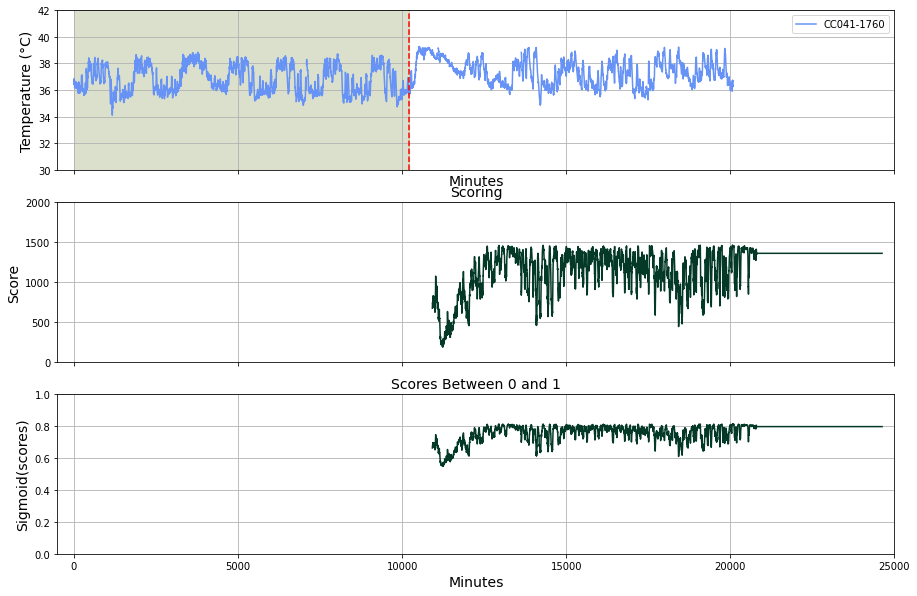

In [15]:
fig,ax = plt.subplots(3,1,figsize=(15,10), sharex = True)
fig.set_facecolor("white")

#importing the model
model = svm.OneClassSVM()

# Sigmoid Definition
beta = (2/2000)
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

# Plotting each file's temperature vs. minutes
for i in range(0, df_temp.shape[1]):
    ax[0].cla()  # clear axis for each individual mouse
    ax[1].cla()
    ax[2].cla()
    
    # Get the specific minutes for the current temperature time series
    mice_min = range(0, df_temp.shape[0])
    
    # Extract the temperature values for the current column
    mice_temp1 = df_temp.iloc[:, i]
    mice_temp = df_temp.iloc[:, i].to_frame()
    
    # Get the column name for the current file
    names = mice_temp.columns[0]
    
    # Filling in missing values using forward fill
    y1_fw = mice_temp1.fillna(method='ffill')
    y1_bw = y1_fw.fillna(method='bfill') #backward fill
    
     # Time Delay Embedding
    Y = tde.tde(y1_bw) #using the tde file
    Y = Y.T #transporting the data
    
    
     
    # Plotting the time series
    ax[0].plot(mice_min, mice_temp1, label=names, color="#6693F5" )  # plotting the time series
    ax[0].grid(True)  # adding a grid
    ax[0].set_xlim(-500, 25000, 2000)
    ax[0].set_ylim(30, 42, 0.5)
    ax[0].set_xlabel("Minutes",fontsize=14)  # x label
    ax[0].set_ylabel('Temperature (°C)',fontsize=14)  # y label
    ax[0].legend()  # name of the mouse
    
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        # Add a vertical line at the infection time
        ax[0].axvline(x=infection_time, color='r', linestyle='--')
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
    else:
        print(f"No match found for mouse '{names}'")
        
    ax[0].axvspan(0,infection_time, color='#8A9A5B', alpha=0.3)
    
    # Fit the Data
    model.fit(Y[:infection_time:10,:]) #training the data for the first 3 days (3*24*60)
                                ###starts on 720 b/c of the tde
                                ###need to change the ending value for Y
    
    # Predict the Data
    predict = model.predict(Y[infection_time+1:,:]) #predicting on the rest of the days
    scores = model.score_samples(Y[infection_time+1:,:]) #scoring on the rest of the days
    
    # Plotting the Scores
    ax[1].plot(mice_min[infection_time+721:], scores, color="#043927") # 5041 = 720 (starting) + 4320 (3 days)
    ax[1].grid()
    ax[1].set_title("Scoring", fontsize=14) # setting a title
    ax[1].set_ylabel("Score", fontsize=14) # y label
    #ax[1].legend() # name of the mouse
    ax[1].set_ylim(0,2000) # y limits
        
    # Values between 0 and 1 using sigmoid
    sig = sigmoid(beta, scores)
    ax[2].plot(mice_min[infection_time+721:], sig, color="#043927")
    ax[2].grid()
    ax[2].set_xlabel('Minutes', fontsize=14)
    ax[2].set_ylabel('Sigmoid(scores)', fontsize=14)
    ax[2].set_title('Scores Between 0 and 1', fontsize=14)
    ax[2].set_ylim(0,1)
        
    
    # Save each plot
    filename = "Scores-Infection-Time/%s_Infection.png" % names  # saving the file as the name of the mouse
    fig.savefig(filename, bbox_inches='tight')
